<a href="https://colab.research.google.com/github/Ninja-State/NMA-DL-Project/blob/Miguel/NMA_DL_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Importing Libraries

import os, requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
#@title CUDA Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
#@title Plotting params

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [4]:
#@title Loading Spiking times
fname1 = ['steinmetz_st.npz']
fname1.append('steinmetz_wav.npz')
fname1.append('steinmetz_lfp.npz')
url2 = ["https://osf.io/4bjns/download"]
url2.append("https://osf.io/ugm9v/download")
url2.append("https://osf.io/kx3v9/download")


for j in range(len(url2)):
  if not os.path.isfile(fname1[j]):
    try:
      r = requests.get(url2[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname1[j], "wb") as fid:
          fid.write(r.content)


dat_ST = np.load('steinmetz_st.npz', allow_pickle=True)['dat']
dat2 = dat_ST[11]
del dat_ST
print(dat2.keys())

dict_keys(['ss', 'ss_passive'])


In [5]:
#@title Load Binned Times

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)



alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx. 
dat = alldat[11]
print(dat.keys())

dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])


In [6]:
#@title DF form
dt_waveforms = 1/30000 # dt of waveform
binsize = dat['bin_size'] # bin times spikes
mean_firing = dat['spks'].mean(axis = (1,2)) * 1/binsize # computing mean firing rate
t_t_peak = dat['trough_to_peak'] * dt_waveforms * 1e3 # computing trough to peak time in ms


labeling_df = pd.DataFrame({
    "Mean Firing Rate": mean_firing,
    "Trough to peak": t_t_peak,
    "Region": dat['brain_area'],
    "Area":dat['brain_area']
})
labeling_df.replace(
    {
        "Area": {"CA1":"Hippocampus","DG":"Hippocampus","SUB":"Hippocampus",
        "VISp": "Visual Ctx", "VISam":"Visual Ctx","MD":"Thalamus","LGd":"Thalamus", "LH":"Thalamus",
        "PL":"Other Ctx","MOs":"Other Ctx","ACA":"Other Ctx"
        }
    }, inplace = True
)

# Labeling according to conditions, other is the default condition
labeling_df['Cell Type'] = "Other"
labeling_df.loc[(labeling_df['Mean Firing Rate']<5)&(labeling_df['Trough to peak']>0.4),'Cell Type'] = "Excitatory"
labeling_df.loc[(labeling_df['Mean Firing Rate']>5)&(labeling_df['Trough to peak']<0.4), 'Cell Type'] = "Inhibitory"

labeling_df.head(20)

,Mean Firing Rate,Trough to peak,Region,Area,Cell Type
0,0.731765,0.800000,VISp,Visual Ctx,Excitatory
1,0.237647,0.666667,VISp,Visual Ctx,Excitatory
2,5.368235,0.766667,VISp,Visual Ctx,Other
3,0.190588,0.566667,DG,Hippocampus,Excitatory
4,1.356471,0.633333,VISp,Visual Ctx,Excitatory
5,0.000000,0.733333,VISp,Visual Ctx,Excitatory
6,0.141176,0.600000,SUB,Hippocampus,Excitatory
7,2.327059,0.733333,DG,Hippocampus,Excitatory
8,0.030588,0.633333,VISp,Visual Ctx,Excitatory
9,0.798824,0.400000,VISp,Visual Ctx,Other


In [7]:
labeling_df['Region'].unique()

array(['VISp', 'DG', 'SUB', 'LGd', 'PL', 'root', 'MOs', 'ACA', 'CA1',
       'VISam', 'MD', 'LH'], dtype=object)

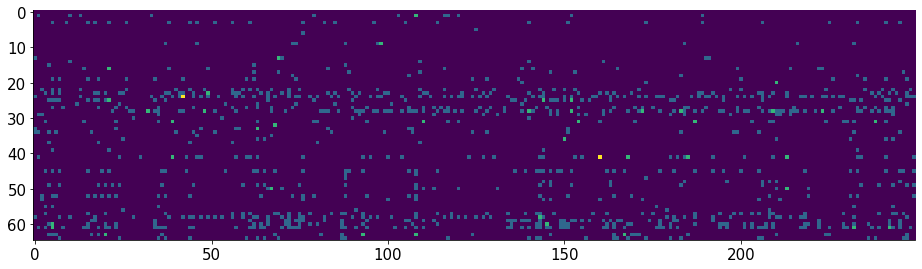

In [8]:
#dat['spks'][1,:,].shape
#Neurons,trials,time
plt.imshow(dat['spks'][dat['brain_area']=='DG',3,:])


In [9]:
dat['spks'][dat['brain_area']=='VISp',:,:30].shape

(66, 340, 30)

In [12]:
#@title Raster visualizer
from ipywidgets import interact
import ipywidgets as widgets
vis_right = dat['contrast_right'] # 0 - low - high
vis_left = dat['contrast_left'] # 0 - low - high
is_correct = np.sign(dat['response'])==np.sign(vis_left-vis_right)
def raster_visualizer(area,trial):
  spikes= dat2['ss']
  plt.figure(figsize=(9,5))
  plt.eventplot(spikes[labeling_df['Area']==area][:,trial],color='k')
  #plt.eventplot(spikes[(labeling_df['Area']==area) & (labeling_df['Cell Type']=='Excitatory')][:,trial]);
  #plt.eventplot(spikes[(labeling_df['Area']==area) & (labeling_df['Cell Type']=='Other')][:,trial],color='k');
  #plt.eventplot(spikes[(labeling_df['Area']==area) & (labeling_df['Cell Type']=='Inhibitory')][:,trial],colors = 'r');
  plt.yticks([]);
  plt.vlines(0.5,0,len(spikes[(labeling_df['Area']==area)])-10,'red','--',alpha=0.5)
  plt.ylabel('Neurons');
  plt.xlabel('Time ($s$)');
  plt.title(f'Trial was correct?:{is_correct[trial]}')
interact(raster_visualizer, area=['Hippocampus','Visual Ctx','Thalamus','Other Ctx'], trial=(0,339));

interactive(children=(Dropdown(description='area', options=('Hippocampus', 'Visual Ctx', 'Thalamus', 'Other Ct…

In [13]:
#@title Mean firing rate based on response
# response = dat['response'] # right - nogo - left (-1, 0, 1)

def mean_firing(area):
  Selection = (labeling_df['Area']==area) #& (labeling_df['Cell Type']=='Excitatory')
  spikes = dat['spks'][Selection].mean(axis = 0) #selecting spikes
  mean_fr_e = spikes[is_correct==True].mean(axis=(0))*1/binsize
  mean_fr_i = spikes[is_correct==False].mean(axis=(0))*1/binsize
  time = binsize * np.arange(dat['spks'].shape[-1])
  plt.plot(time, mean_fr_e,label='correct')
  plt.plot(time, mean_fr_i,label='incorrect')
  plt.axvline(x=0.5,ls = '--', alpha = 0.5, c = 'r', label='Stim')
  plt.axvline(x=np.mean(dat['response_time']),ls = '--', alpha = 0.5, c = 'k', label='Response')
  plt.ylabel('Mean Firing Rate ($Hz$)')
  plt.xlabel('Time ($ms$)')
  plt.legend()
interact(mean_firing, area=['Hippocampus','Visual Ctx','Thalamus','Other Ctx']);

interactive(children=(Dropdown(description='area', options=('Hippocampus', 'Visual Ctx', 'Thalamus', 'Other Ct…